# Introduction

In this notebook, I will first have a look on the dataset with some visualizations, then I will try to create a legendary pokemon recognizer, then I will try to create new legendary pokemons using this recognizer inside a generator.

In [1]:
# Let's check our input file
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

pokemon.csv



# Import section

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. I like it most for plot
%matplotlib inline
from sklearn.linear_model import LogisticRegression # to apply the Logistic regression
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.cross_validation import KFold # use for cross validation
from sklearn.model_selection import GridSearchCV# for tuning parameter
from sklearn.ensemble import RandomForestClassifier # for random forest classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm # for Support Vector Machine
from sklearn import metrics # for the check the error and accuracy of the model

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Explore data

## Basic exploration

In [3]:
# Import data into a Pandas Dataframe
data = pd.read_csv("../input/pokemon.csv")

In [4]:
# Let's check the columns we have
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 41 columns):
abilities            801 non-null object
against_bug          801 non-null float64
against_dark         801 non-null float64
against_dragon       801 non-null float64
against_electric     801 non-null float64
against_fairy        801 non-null float64
against_fight        801 non-null float64
against_fire         801 non-null float64
against_flying       801 non-null float64
against_ghost        801 non-null float64
against_grass        801 non-null float64
against_ground       801 non-null float64
against_ice          801 non-null float64
against_normal       801 non-null float64
against_poison       801 non-null float64
against_psychic      801 non-null float64
against_rock         801 non-null float64
against_steel        801 non-null float64
against_water        801 non-null float64
attack               801 non-null int64
base_egg_steps       801 non-null int64
base_happiness    

In [5]:
# Let's see how data look like
data.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


## Clean data for further exploration

There are some null Objects in type2, so we will convert NaN values into the string "None".

In [6]:
data['type2'].fillna('None', inplace=True)

`capture_rate` is for the most an integer, but have some strings in some rare cases. We will convert this column into integers, replacing strings by `NaN`

In [7]:
# Replace strings by NaN value, and convert numbers into an actual number type
data['capture_rate'] = pd.to_numeric(data['capture_rate'], errors='coerce')

`type1`, `type2`, `abilities`, and `classfication` are some strings. As these parameters will likely be processed with other columns, we will convert them into numbers thanks simple conversion tables. Each string will be represented by an ID.

In [8]:
# Create the type <-> ID conversion dictionary
all_types = set(data['type1']).union(set(data['type2']))
type_id_dict = dict(zip(list(all_types), range(len(all_types))))

all_abilities = set(data['abilities'])
abilities_id_dict = dict(zip(all_abilities, range(len(all_abilities))))

all_classf = set(data['classfication'])
classf_id_dict = dict(zip(all_classf, range(len(all_classf))))

In [9]:
# Convert types in the Dataframe
for type_name, type_id in type_id_dict.items():
    data['type1'].replace(type_name, type_id, inplace=True)
    data['type2'].replace(type_name, type_id, inplace=True)
    
for ability_name, ability_id in abilities_id_dict.items():
    data['abilities'].replace(ability_name, ability_id, inplace=True)

for classf_name, classf_id in classf_id_dict.items():
    data['classfication'].replace(classf_name, classf_id, inplace=True)
   
data[['type1', 'type2', 'classfication', 'abilities']].head()

,type1,type2,classfication,abilities
0,14,13,145,222
1,14,13,145,222
2,14,13,145,222
3,6,8,377,387
4,6,8,322,387


## Data split

Now we can split data into different groups. Here we choose to split columns into the following categories of info:
* **in-combat** parameters (like attack and defense)
* **off-combat** parameters (like gender ratio)
* **out-of-gameplay** parameters (like name and ID)

In [10]:
in_combat_col = ['against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_total', 'defense', 'hp', 'sp_attack', 'sp_defense', 'speed', 
        'type1', 'type2']
off_combat_col = ['abilities', 'base_egg_steps', 'base_happiness', 'capture_rate',
       'classfication', 'experience_growth', 'height_m', 'percentage_male', 
       'weight_kg', 'is_legendary']
out_of_gameplay_col = ['japanese_name', 'name', 'pokedex_number', 'generation']

# Check that the list do not overlap amongst themselves
if not set(in_combat_col).intersection(set(off_combat_col)) \
   and not set(in_combat_col).intersection(set(out_of_gameplay_col)) \
   and not set(off_combat_col).intersection(set(out_of_gameplay_col)):
    print("☑ Lists do not overlap :)")
else:
    print("Lists overlap !")

☑ Lists do not overlap :)


## Data correlations

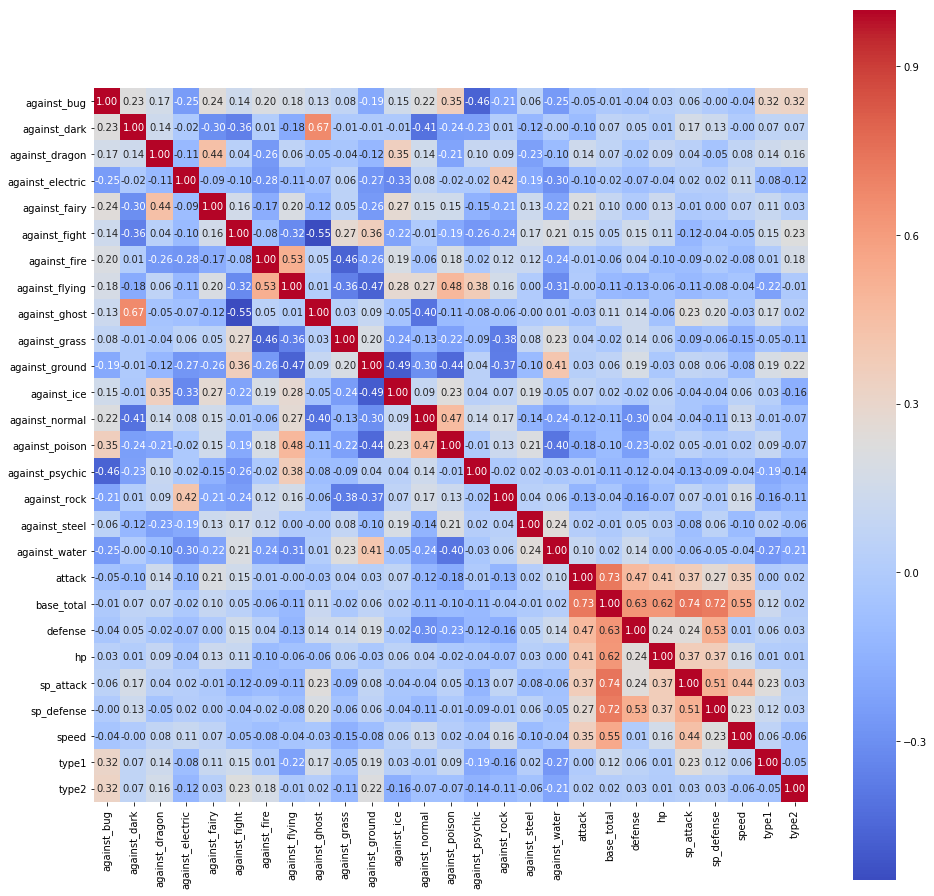

In [11]:
# Let's find redondant information with a simple cross-correlation
corr = data[in_combat_col].corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr, cbar=True, square=True, annot=True, fmt='.2f',annot_kws={'size': 10},
            xticklabels=in_combat_col, yticklabels=in_combat_col, cmap= 'coolwarm')

We can observe that there is not any strong correlation, so no column to remove. Nonetheless, `base_total` has a cross-correlation value over 0.5 with several other items, which indicates that this value is well represented by a set of other values and is not necessary in our dataset. Moreover, this column is not described in the dataset presentation and I could not find any documentation about it. For these reasons, I decide to remove this column from the dataset.

In [12]:
# Remove base_total
data.drop("base_total", axis=1, inplace=True)
in_combat_col.remove("base_total")

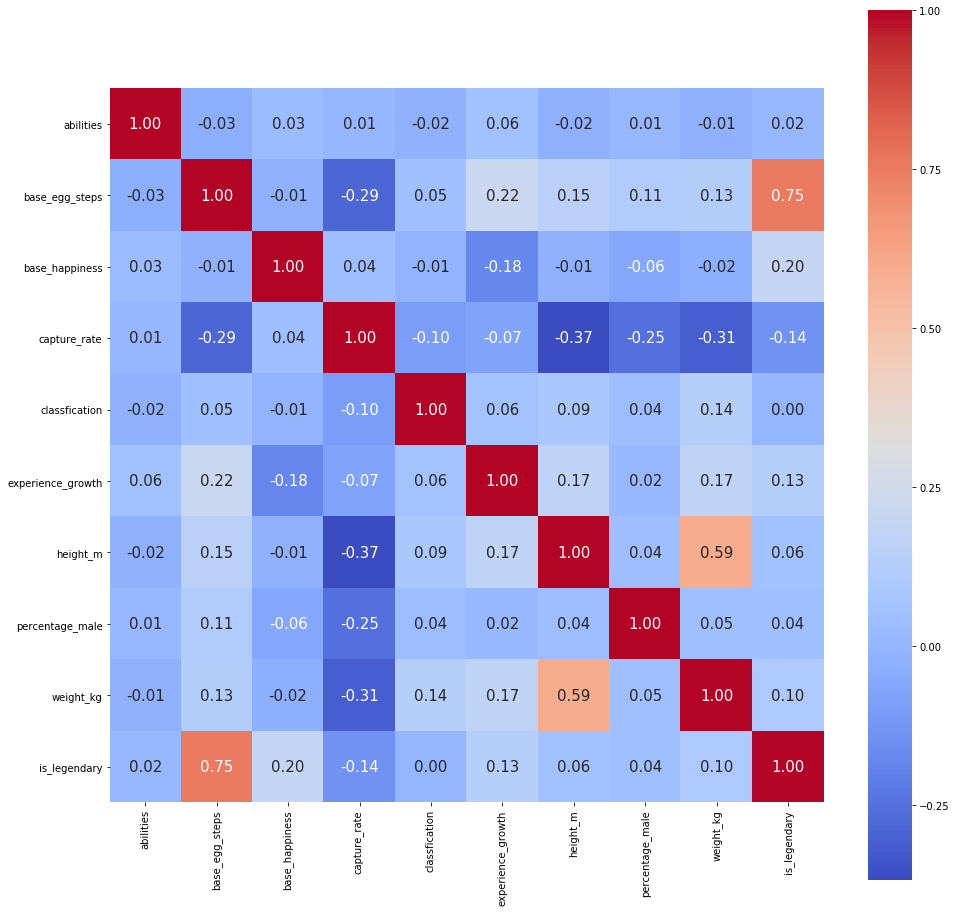

In [13]:
# Let's do the same with off-combat parameters
corr = data[off_combat_col].dropna(axis=0).corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr, cbar=True, square=True, annot=True, fmt='.2f',annot_kws={'size': 15},
            xticklabels=off_combat_col, yticklabels=off_combat_col, cmap= 'coolwarm')

We can observe that there is a strong correlation between `is_legendary` and `base_egg_steps`

## Data visualization about legendary Pokemon

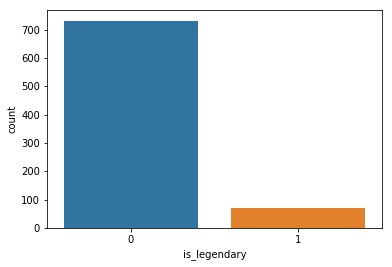

In [14]:
# Let's see the number of legendary pokemon in data
sns.countplot(data['is_legendary'])

### Legendary VS in-combat parameters

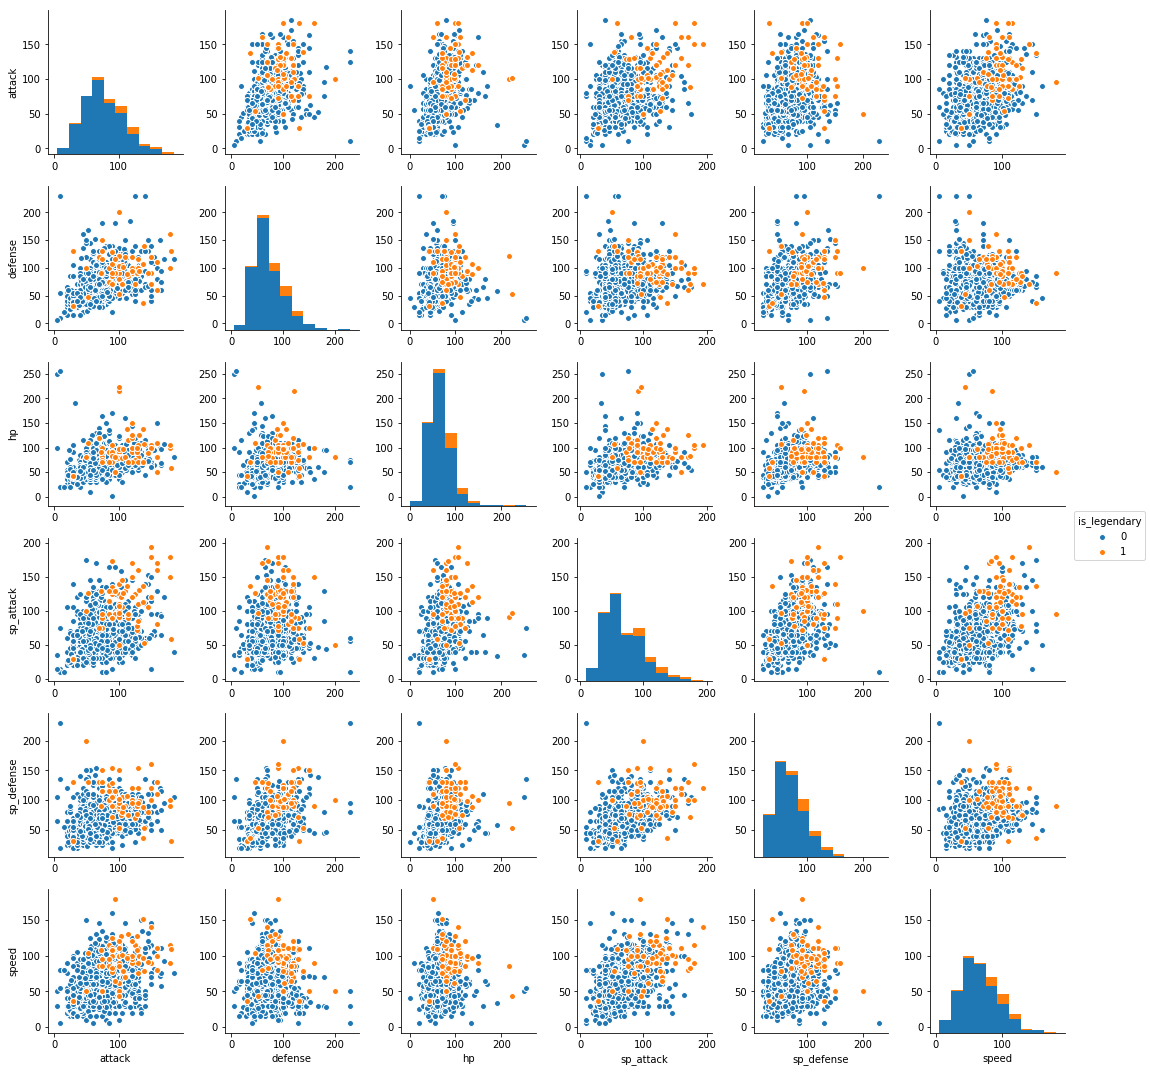

In [15]:
# Let's find relations between beeing a legendary pokemon or not, and the basic combat parameters
# We do not use in_combat_col because there are too many columns to plot
basic_in_combat_col = ['attack', 'defense', 'hp', 'sp_attack', 'sp_defense', 'speed']

sns.pairplot(data, vars=basic_in_combat_col, hue="is_legendary")

We can see that by taking parameters in pairs, there is no clear separation between legendary and non-legendary pokemons. Meanwhile, legendary pokemons have all of their parameters with high values. We therefore may expect that the combination of every parameters shows a clear separation.

To do so, we will basically try to make the sum of these parameters, and observe the new repartition of legendary pokemons. We must take care to use normalized data to give each parameter the same weight.

In [16]:
# Let's compute the sum of these parameters and store them in a new column
# We first need to normalize the data to do a relevant sum
basic_combat_df = data[basic_in_combat_col]
norm_data = (basic_combat_df - basic_combat_df.mean()) / (basic_combat_df.max() - basic_combat_df.min())
norm_data['sum'] = norm_data.sum(axis=1, numeric_only=True)
# Add the is_legendary column
norm_data['is_legendary'] = data['is_legendary']
norm_data.head()

,attack,defense,hp,sp_attack,sp_defense,speed,sum,is_legendary
0,-0.160320,-0.106706,-0.094326,-0.034271,-0.028149,-0.121912,-0.545684,0
1,-0.088098,-0.044483,-0.035271,0.047251,0.043279,-0.036198,-0.113520,0
2,0.123013,0.222183,0.043469,0.275512,0.233755,0.078088,0.976021,0
3,-0.143654,-0.133372,-0.117948,-0.061445,-0.099578,-0.007626,-0.563623,0
4,-0.076987,-0.066706,-0.043145,0.047251,-0.028149,0.078088,-0.089648,0


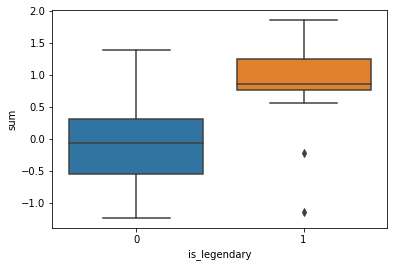

In [17]:
# Let's display the repartition of legendary pokemon in funciton of this sum
sns.boxplot(data=norm_data, x='is_legendary', y='sum')

According to this boxplot, there is a clear correlation between the legendary status and the sum of all basic combat parameters. But both classes still overlap, and this sum cannot be the single value to consider to do a legendary recognizer.

Let's do the same for other parameters of the list *in-combat*.

In [18]:
other_in_combat_col = ['against_psychic', 'against_grass', 'against_flying', 
                       'against_ground', 'against_water', 'against_electric', 
                       'against_fire', 'against_fairy', 'against_dark', 'against_ice', 
                       'against_steel', 'against_bug', 'against_normal', 'against_poison', 
                       'against_ghost', 'against_rock', 'against_fight', 'against_dragon']

In [19]:
# Let's compute the sum of these parameters and store them in a new column
# We first need to normalize the data to do a relevant sum
other_in_combat_df = data[other_in_combat_col]
norm_data = (other_in_combat_df - other_in_combat_df.mean()) / (other_in_combat_df.max() - other_in_combat_df.min())
norm_data['sum'] = norm_data.sum(axis=1, numeric_only=True)
# Add the is_legendary column
norm_data['is_legendary'] = data['is_legendary']
norm_data.head()

,against_psychic,against_grass,against_flying,against_ground,against_water,against_electric,against_fire,against_fairy,against_dark,against_ice,against_steel,against_bug,against_normal,against_poison,against_ghost,against_rock,against_fight,against_dragon,sum,is_legendary
0,0.248674,-0.209072,0.215231,-0.024501,-0.148897,-0.143493,0.230545,-0.151727,-0.015231,0.211153,0.004411,0.000999,0.112984,0.006164,0.003745,-0.066750,-0.141386,0.015605,0.148455,0
1,0.248674,-0.209072,0.215231,-0.024501,-0.148897,-0.143493,0.230545,-0.151727,-0.015231,0.211153,0.004411,0.000999,0.112984,0.006164,0.003745,-0.066750,-0.141386,0.015605,0.148455,0
2,0.248674,-0.209072,0.215231,-0.024501,-0.148897,-0.143493,0.230545,-0.151727,-0.015231,0.211153,0.004411,0.000999,0.112984,0.006164,0.003745,-0.066750,-0.141386,0.015605,0.148455,0
3,-0.001326,-0.142405,-0.051436,0.225499,0.251103,-0.018493,-0.169455,-0.151727,-0.015231,-0.188847,-0.128922,-0.132335,0.112984,0.006164,0.003745,0.199917,-0.016386,0.015605,-0.201545,0
4,-0.001326,-0.142405,-0.051436,0.225499,0.251103,-0.018493,-0.169455,-0.151727,-0.015231,-0.188847,-0.128922,-0.132335,0.112984,0.006164,0.003745,0.199917,-0.016386,0.015605,-0.201545,0


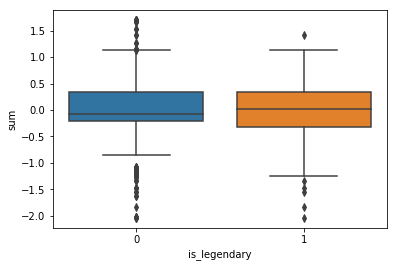

In [20]:
# Let's display the repartition of legendary pokemon in funciton of this sum
sns.boxplot(data=norm_data, x='is_legendary', y='sum')

Legendary pokemons cannot be determined using the `against_X` parameters.

And finally, what about the types ?

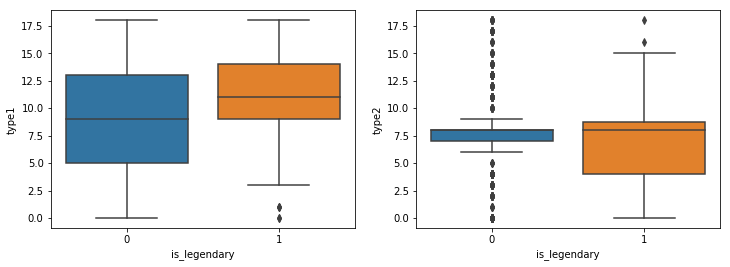

In [21]:
# Let's display the repartition of legendary pokemon in function of types
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
sns.boxplot(ax=axs[0], data=data[['type1','is_legendary']], x='is_legendary', y='type1')
sns.boxplot(ax=axs[1], data=data[['type2','is_legendary']], x='is_legendary', y='type2')

## Legendary VS off-combat parameters

Instead of displaying the repartition of legendaries per pair of features, let's display it for each one.

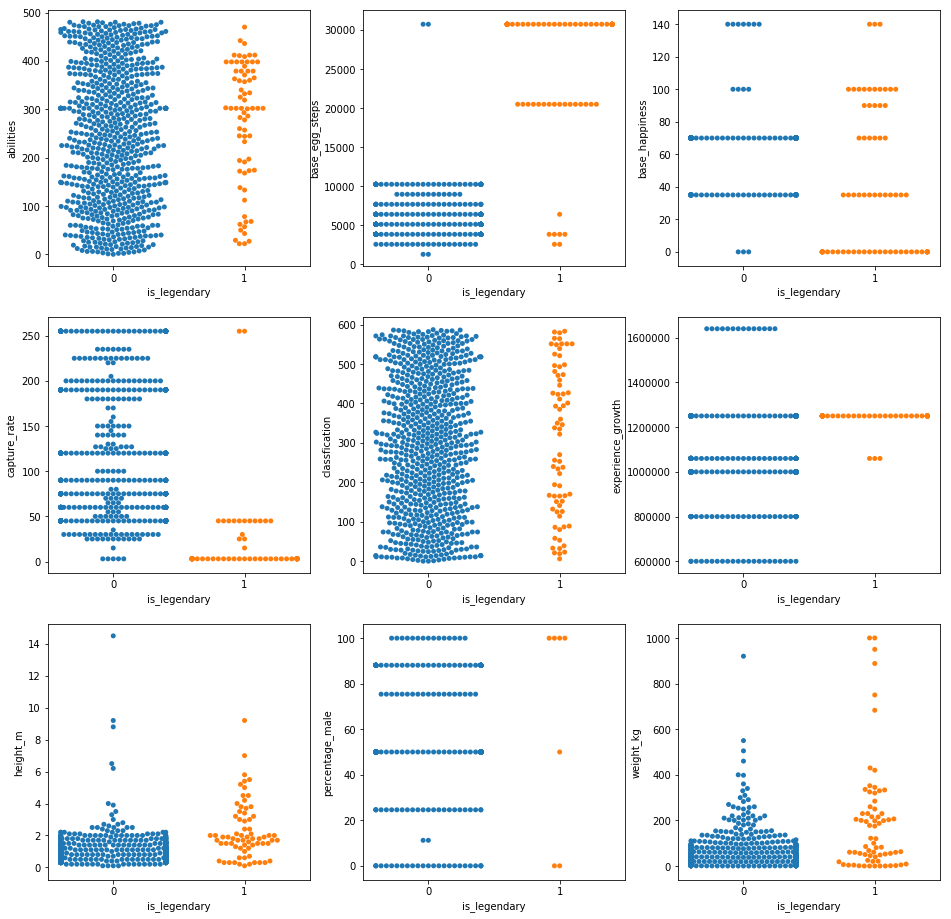

In [22]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(16,16))
for i, col in enumerate([c for c in off_combat_col if c !="is_legendary"]):
    sns.swarmplot(ax=axs[i//3][i%3], data=data, x='is_legendary', y=col)

According to these vizualisations, we can safely remove the following items from the prediction variables:
* classfication
* abilities



In the columns `weight_kg`, `height_m`, and `percentage_male`, there are a lot of missing data (`NaN` value). Let's see how many legendary pokemon are concerned by these missing data.

In [23]:
d = {}
d['with_everything'] = data['is_legendary']
d['without_nan_capture'] = data.dropna(axis=0, how='any', subset=['capture_rate'])['is_legendary']
d['without_nan_weight'] = data.dropna(axis=0, how='any', subset=['weight_kg'])['is_legendary']
d['without_nan_height'] = data.dropna(axis=0, how='any', subset=['height_m'])['is_legendary']
d['without_nan_height_weight'] = data.dropna(axis=0, how='any', subset=['height_m', 'weight_kg'])['is_legendary']
d['without_nan_male'] = data.dropna(axis=0, how='any', subset=['percentage_male'])['is_legendary']
for key, s in d.items():
    print("{} : \n{}".format(key, s.value_counts()))

legendary_serie_without_nan = data.dropna(axis=0, how='any')['is_legendary']
legendary_serie_with_nan = data['is_legendary']

with_everything : 
0    731
1     70
Name: is_legendary, dtype: int64
without_nan_capture : 
0    730
1     70
Name: is_legendary, dtype: int64
without_nan_weight : 
0    712
1     69
Name: is_legendary, dtype: int64
without_nan_height : 
0    712
1     69
Name: is_legendary, dtype: int64
without_nan_height_weight : 
0    712
1     69
Name: is_legendary, dtype: int64
without_nan_male : 
0    696
1      7
Name: is_legendary, dtype: int64


Result is we only lose 1 legendary pokemon by dropping NaN values in both `weight_kg` and `height_m` columns, but we lose 63 pokemons by dropping NaN values in `percentage_male` column. We now decide to remove `percentage_male` from used features for recognition, and we drop the line containing a NaN for weight and height.

We can now prepare the list `useful_off_combat_col` for the recognizer, containing only the necessary features.

In [24]:
useful_off_combat_col = off_combat_col.copy()
for col in ['abilities', 'classfication', 'is_legendary', 'percentage_male']:
    if col in useful_off_combat_col:
        useful_off_combat_col.remove(col)

# Drop rows where there is a NaN in height_m, weight_kg, or capture_rate
subset = ['height_m', 'weight_kg', 'capture_rate']
data = data.dropna(axis=0, how='any', subset=subset)

# Legendary recognizer

Prepare data for recognizers.

In [25]:
#now split our data into train and test
train, test = train_test_split(data, test_size=0.3)# in this our main data is splitted into train and test
# we can check their dimension
print(train.shape)
print(test.shape)

train_y = train['is_legendary']# This is output of our training data
test_y = test['is_legendary']   #output value of test dat

(546, 40)
(234, 40)


## With basic combat features only

In [26]:
prediction_var = basic_in_combat_col.copy()

In [27]:
train_X = train[prediction_var]# taking the training data input 
test_X= test[prediction_var] # taking test data inputs

### Random forest

In [28]:
model=RandomForestClassifier(n_estimators=100)# a simple random forest model
model.fit(train_X,train_y)# now fit our model for training data
prediction=model.predict(test_X)# predict for the test data
metrics.accuracy_score(prediction,test_y) # to check the accuracy
# here we will use accuracy measurement between our predicted value and our test output values

0.92307692307692313

### SVM

In [29]:
model = svm.SVC()
model.fit(train_X,train_y)
prediction=model.predict(test_X)
metrics.accuracy_score(prediction,test_y)

0.9145299145299145

## With off-combat features only

We remove the features we considered as useless in the previous section.

In [30]:
prediction_var = useful_off_combat_col.copy()
prediction_var

['base_egg_steps',
 'base_happiness',
 'capture_rate',
 'experience_growth',
 'height_m',
 'weight_kg']

In [31]:
train_X = train[prediction_var]# taking the training data input 
test_X = test[prediction_var] # taking test data inputs

In [32]:
np.isfinite(train_X).all()

base_egg_steps       True
base_happiness       True
capture_rate         True
experience_growth    True
height_m             True
weight_kg            True
dtype: bool

### Random Forest

In [33]:
model=RandomForestClassifier(n_estimators=100)# a simple random forest model
model.fit(train_X,train_y)# now fit our model for training data
prediction=model.predict(test_X)# predict for the test data
metrics.accuracy_score(prediction,test_y) # to check the accuracy
# here we will use accuracy measurement between our predicted value and our test output values

0.99572649572649574

### SVM

In [34]:
model = svm.SVC()
model.fit(train_X,train_y)
prediction=model.predict(test_X)
metrics.accuracy_score(prediction,test_y)

0.92735042735042739

## Using both basic-combat and off-combat features

In [35]:
prediction_var = (useful_off_combat_col + basic_in_combat_col).copy()
prediction_var

['base_egg_steps',
 'base_happiness',
 'capture_rate',
 'experience_growth',
 'height_m',
 'weight_kg',
 'attack',
 'defense',
 'hp',
 'sp_attack',
 'sp_defense',
 'speed']

In [36]:
train_X = train[prediction_var]# taking the training data input 
test_X = test[prediction_var] # taking test data inputs

### Random Forest

In [37]:
model=RandomForestClassifier(n_estimators=100)# a simple random forest model
model.fit(train_X,train_y)# now fit our model for training data
prediction=model.predict(test_X)# predict for the test data
metrics.accuracy_score(prediction,test_y) # to check the accuracy
# here we will use accuracy measurement between our predicted value and our test output values

0.99572649572649574

Let's find out what are the most important features for this algorithm

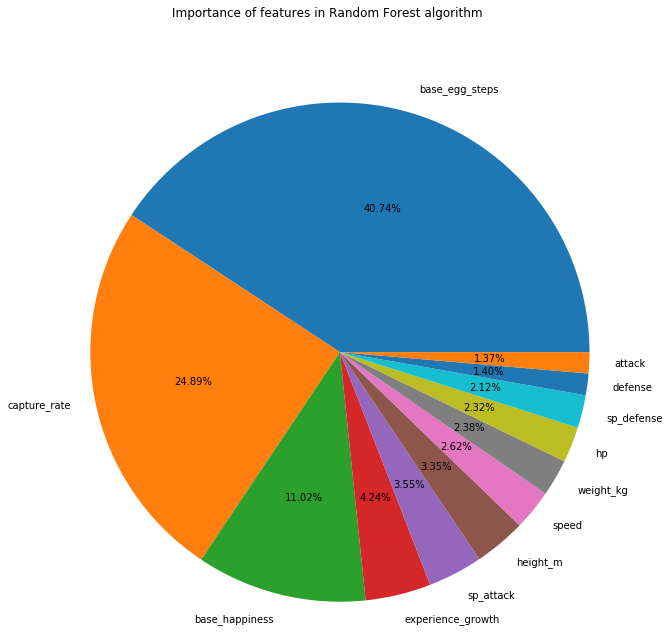

In [38]:
sorted_features = sorted(zip(model.feature_importances_, train_X.columns), reverse=True)
unzip_sorted_features = list(zip(*sorted_features))
labels = unzip_sorted_features[1]
scores = unzip_sorted_features[0]

fig1, ax1 = plt.subplots()
fig1.suptitle("Importance of features in Random Forest algorithm")
fig1.set_figheight(10)
fig1.set_figwidth(10)
ax1.pie(scores, labels=labels, autopct='%1.2f%%',
        shadow=False, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [39]:
model=RandomForestClassifier(n_estimators=100)# a simple random forest model
model.fit(train_X[['base_egg_steps', 'capture_rate', 'base_happiness']],
          train_y)# now fit our model for training data
prediction=model.predict(test_X[['base_egg_steps', 'capture_rate', 'base_happiness']])# predict for the test data
metrics.accuracy_score(prediction,test_y) # to check the accuracy

0.99572649572649574

As we can see, three features hide all of the other ones. This is a problem for our generator that aims at giving a relevant value for each one of them. So let us try to combine two different classifiers:
* One using the three most important features
* One using the other ones